<a href="https://colab.research.google.com/github/AnushkaSamaranayake/Graph-Neural-Networks-GCN-and-GAT/blob/main/GNN_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip show torch_geometric

In [4]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.3 MB/s eta 0:00:00


In [5]:
!pip show torch_geometric

Name: torch-geometric
Version: 2.7.0
Summary: Graph Neural Network Library for PyTorch
Home-page: https://pyg.org
Author: 
Author-email: Matthias Fey <matthias@pyg.org>
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: aiohttp, fsspec, jinja2, numpy, psutil, pyparsing, requests, tqdm, xxhash
Required-by: 


In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

cora_dataset = Planetoid(root='Cora_data', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [7]:
len(cora_dataset)

1

Each node is containing 1433 features and one of them are indicating presence of a word in the dictionary

In [8]:
cora_dataset.num_features

1433

In [9]:
cora_graph=cora_dataset[0]

In [10]:
cora_graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

x = 2708 individual nodes each having 1433 features.

edge_index = 2 - source and target nodes, 10556 - columns(edges)

y = 2708 labels determining nodes

In [11]:
print(len(cora_graph.x[0]))
cora_graph.x[0]

1433


tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [12]:
print("Training Samples: ", cora_graph.train_mask.sum().item())
print("validation Samples: ", cora_graph.val_mask.sum().item())
print("Testing Samples: ", cora_graph.test_mask.sum().item())



Training Samples:  140
validation Samples:  500
Testing Samples:  1000


In [13]:
print(f"Number of nodes: {cora_graph.num_nodes}")
print(f"Number of edges: {cora_graph.num_edges}")
print(f"Average node degree: {cora_graph.num_edges/cora_graph.num_nodes:.2f}")
print(f"Has isolated nodes: {cora_graph.has_isolated_nodes()}")
print(f"Has self-loops: {cora_graph.has_self_loops()}")
print(f"Is undirected: {cora_graph.is_undirected()}")

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [14]:
cora_dataset.num_classes

7

Each of publications(nodes) are belong to one of the category below

In [15]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"
}

cora_graph.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

{np.int64(3): 818, np.int64(4): 426, np.int64(0): 351, np.int64(2): 418, np.int64(1): 217, np.int64(5): 298, np.int64(6): 180}


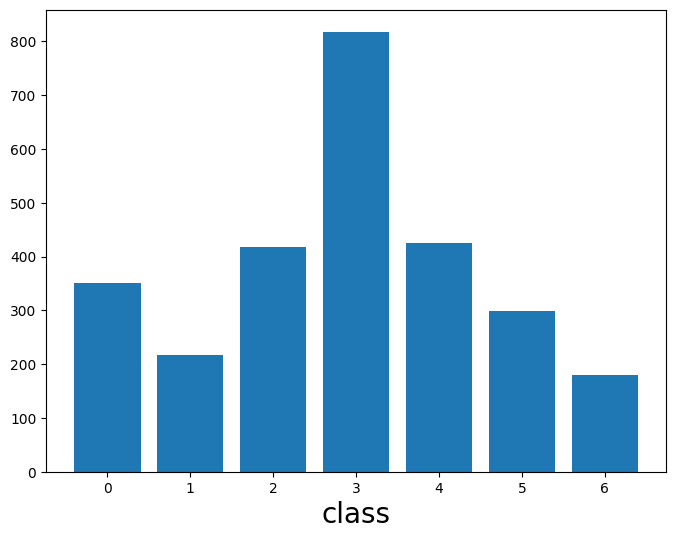

In [16]:
import collections
import matplotlib.pyplot as plt

counter = collections.Counter(cora_graph.y.numpy())
counter = dict(counter)
print(counter)

count = [x[1] for x in sorted(counter.items())]

plt.figure(figsize= (8,6))
plt.bar(range(7), count)
plt.xlabel("class", size = 20)
plt.show()

### Graph representation

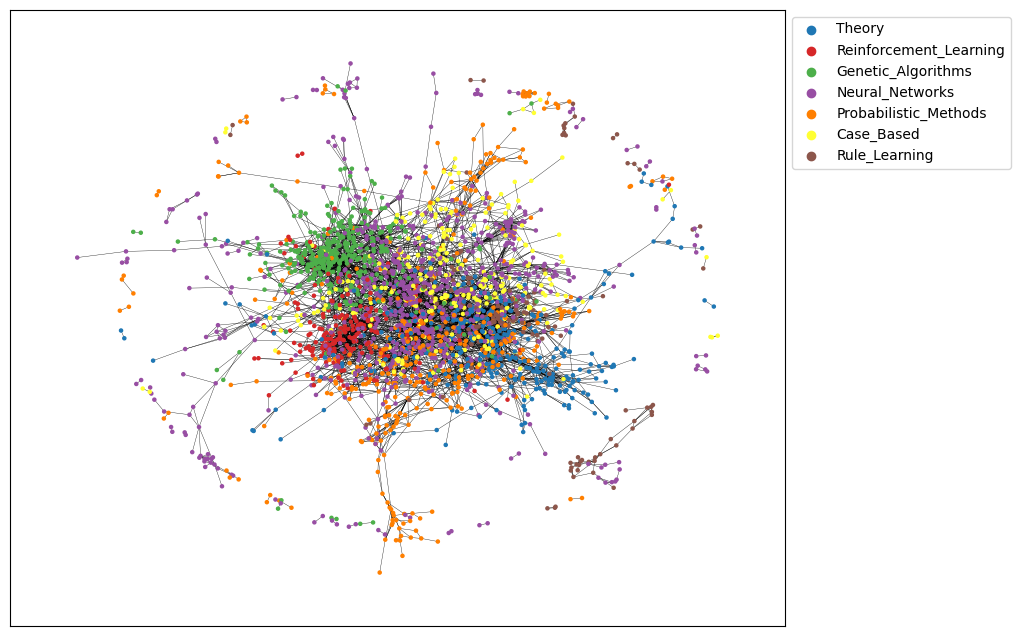

In [17]:
import networkx as nx
from torch_geometric.utils import to_networkx

label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"
}

colorlist = ['#1f77b4','#d62728','#4daf4a','#984ea3','#ff7f00','#ffff33','#8c564b']

G = to_networkx(cora_graph, to_undirected=True)

node_color = [colorlist[int(label)] for label in cora_graph.y]
labellist = [label_dict[int(label)] for label in cora_graph.y]

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10,8))

nx.draw_networkx_nodes(G, pos, node_size=5, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=0.25)

for label, color in zip(label_dict.values(), colorlist):
    plt.scatter([], [], c=color, label=label)

plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

## Graph Convolutional Network

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self, input_channels, output_channels, hidden_channels = 16):
    torch.manual_seed(223)

    super().__init__()
    self.conv1 = GCNConv(in_channels=input_channels, out_channels=hidden_channels)
    self.conv2 = GCNConv(in_channels=hidden_channels, out_channels=output_channels)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    x = self.conv1(x, edge_index)
    x = x.relu()

    x = F.dropout(x, p = 0.5, training = self.training)

    x = self.conv2(x, edge_index)

    return x

### Data

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cora_graph = cora_dataset[0].to(device)

input_channels = cora_dataset.num_features

output_channels = cora_dataset.num_classes

In [26]:
model = GCN(
    input_channels=input_channels,
    output_channels=output_channels
).to(device)

print(model)

print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Number of parameters:  23063


### Data visulaization function

In [28]:
from sklearn.manifold import TSNE

def visualize(h,color):
  z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

  plt.figure(figsize=(10,8))
  plt.xticks([])
  plt.yticks([])

  plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
  plt.show()


Node embedding shape:  torch.Size([2708, 7])


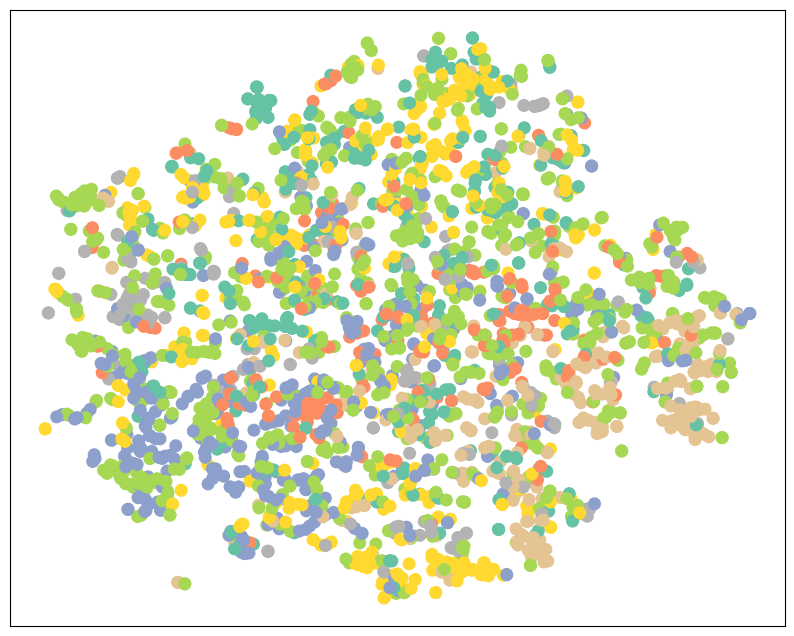

In [29]:
model.eval()
out = model(cora_graph)

print("Node embedding shape: ", out.shape)
visualize(out, color=cora_graph.cpu().y)


## Training GCN model

In [30]:
model = GCN(
    input_channels=input_channels,
    output_channels=output_channels
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss()


No storing the weights having good accuracy

In [31]:
%%time

num_epochs = 200

cora_graph = cora_dataset[0].to(device)

for epoch in range(num_epochs):
  model.train()

  optimizer.zero_grad()

  out = model(cora_graph)

  loss = criterion(out[cora_graph.train_mask], cora_graph.y[cora_graph.train_mask])
  loss.backward()

  optimizer.step()

  #predictions on training data
  pred_train = out.argmax(dim=1)

  correct_train = (
      pred_train[cora_graph.train_mask] == cora_graph.y[cora_graph.train_mask]
  ).sum()

  acc_train = int(correct_train) / int(cora_graph.train_mask.sum())

  #print training loss

  if (epoch + 1) % 10 == 0:
    print(f"Epoch: {epoch + 1:03d}, Train Loss: {loss:.3f}, Train Acc: {acc_train:.3f}")


Epoch: 010, Train Loss: 1.896, Train Acc: 0.671
Epoch: 020, Train Loss: 1.778, Train Acc: 0.729
Epoch: 030, Train Loss: 1.617, Train Acc: 0.850
Epoch: 040, Train Loss: 1.437, Train Acc: 0.793
Epoch: 050, Train Loss: 1.203, Train Acc: 0.857
Epoch: 060, Train Loss: 0.997, Train Acc: 0.900
Epoch: 070, Train Loss: 0.853, Train Acc: 0.936
Epoch: 080, Train Loss: 0.739, Train Acc: 0.893
Epoch: 090, Train Loss: 0.689, Train Acc: 0.921
Epoch: 100, Train Loss: 0.576, Train Acc: 0.950
Epoch: 110, Train Loss: 0.570, Train Acc: 0.943
Epoch: 120, Train Loss: 0.562, Train Acc: 0.929
Epoch: 130, Train Loss: 0.496, Train Acc: 0.957
Epoch: 140, Train Loss: 0.457, Train Acc: 0.950
Epoch: 150, Train Loss: 0.421, Train Acc: 0.957
Epoch: 160, Train Loss: 0.412, Train Acc: 0.964
Epoch: 170, Train Loss: 0.401, Train Acc: 0.950
Epoch: 180, Train Loss: 0.359, Train Acc: 0.986
Epoch: 190, Train Loss: 0.329, Train Acc: 0.979
Epoch: 200, Train Loss: 0.320, Train Acc: 0.986
CPU times: user 702 ms, sys: 108 ms, tot

### Testing

In [32]:
model.eval()

with torch.no_grad():
  pred = model(cora_graph).argmax(dim = 1)

  correct = (pred[cora_graph.test_mask] == cora_graph.y[cora_graph.test_mask]).sum().item()

  test_acc = correct / cora_graph.test_mask.sum().item()

print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.7950


79% accuracy is obtained from the test data but not good.

No validation data is used. next used the validation data to save the weights of the best model.

In [33]:
model = GCN(
    input_channels=input_channels,
    output_channels=output_channels
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss()

In [34]:
%%time

import copy

num_epochs = 200

# Keep track of best validation accuracy and the best model state
best_acc_val = 0.0
best_model_state = None

for epoch in range(num_epochs):
  model.train()
  optimizer.zero_grad()

  out = model(cora_graph)

  loss = criterion(out[cora_graph.train_mask], cora_graph.y[cora_graph.train_mask])
  loss.backward()

  optimizer.step()

  #predictions on training data
  pred_train = out.argmax(dim=1)

  correct_train = (
      pred_train[cora_graph.train_mask] == cora_graph.y[cora_graph.train_mask]
  ).sum()

  acc_train = int(correct_train) / int(cora_graph.train_mask.sum())

  model.eval()

  with torch.no_grad():
    pred_val = model(cora_graph).argmax(dim = 1)

    correct_val = (
        pred_val[cora_graph.val_mask] == cora_graph.y[cora_graph.val_mask]
    ).sum()

    acc_val = int(correct_val) / int(cora_graph.val_mask.sum())

  if acc_val > best_acc_val:
    best_acc_val = acc_val

    best_model_state = copy.deepcopy(model.state_dict())


  if (epoch + 1) % 10 == 0:
    print(f"Epoch: {epoch + 1:03d}, Train Loss: {loss:.3f}, Train Acc: {acc_train:.3f}, Val Acc: {acc_val:.3f}")


Epoch: 010, Train Loss: 1.896, Train Acc: 0.671, Val Acc: 0.640
Epoch: 020, Train Loss: 1.778, Train Acc: 0.729, Val Acc: 0.674
Epoch: 030, Train Loss: 1.617, Train Acc: 0.850, Val Acc: 0.750
Epoch: 040, Train Loss: 1.437, Train Acc: 0.793, Val Acc: 0.748
Epoch: 050, Train Loss: 1.203, Train Acc: 0.857, Val Acc: 0.750
Epoch: 060, Train Loss: 0.997, Train Acc: 0.900, Val Acc: 0.754
Epoch: 070, Train Loss: 0.853, Train Acc: 0.936, Val Acc: 0.764
Epoch: 080, Train Loss: 0.739, Train Acc: 0.893, Val Acc: 0.772
Epoch: 090, Train Loss: 0.689, Train Acc: 0.921, Val Acc: 0.782
Epoch: 100, Train Loss: 0.576, Train Acc: 0.950, Val Acc: 0.780
Epoch: 110, Train Loss: 0.570, Train Acc: 0.943, Val Acc: 0.786
Epoch: 120, Train Loss: 0.562, Train Acc: 0.929, Val Acc: 0.786
Epoch: 130, Train Loss: 0.496, Train Acc: 0.957, Val Acc: 0.780
Epoch: 140, Train Loss: 0.457, Train Acc: 0.950, Val Acc: 0.788
Epoch: 150, Train Loss: 0.421, Train Acc: 0.957, Val Acc: 0.792
Epoch: 160, Train Loss: 0.412, Train Acc

In [35]:
#load best model
print("Best validation accuracy: ", best_acc_val)

model.load_state_dict(best_model_state)

Best validation accuracy:  0.792


<All keys matched successfully>

In [36]:
model.eval()
with torch.no_grad():
  pred = model(cora_graph).argmax(dim = 1)

  correct = (pred[cora_graph.test_mask] == cora_graph.y[cora_graph.test_mask]).sum().item()

  test_acc = correct / cora_graph.test_mask.sum().item()

print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8030


Node embedding shape:  torch.Size([2708, 7])


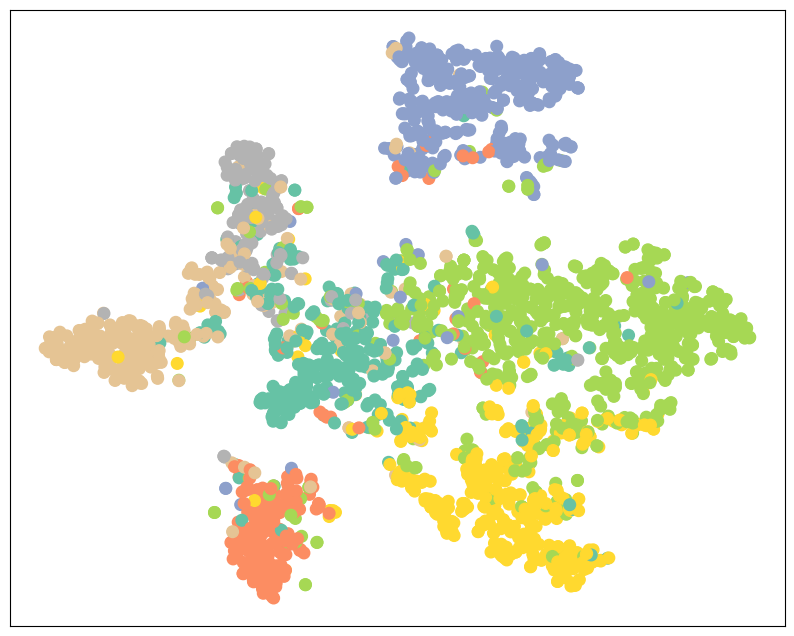

In [37]:
model.eval()
out = model(cora_graph)

print("Node embedding shape: ", out.shape)
visualize(out, color=cora_graph.cpu().y)